In [219]:
myarr = np.array([
    [1, 2, 3],
    [10, 20, 30],
    ])
adj = (1, 2, 3)
myarr - adj

array([[ 0,  0,  0],
       [ 9, 18, 27]])

In [294]:
import abc
from collections import UserList

import numpy as np
from scipy.spatial.transform import Rotation


def svg_polygon(arr, fill='red'):
    pointstr = ' '.join(f"{x},{y}" for x, y in arr)
    return f'''<polygon fill="{fill}" points="{pointstr}"/>'''

def svg(width, height, *svgelements):
    return (
        f'''<svg width="{width}" height="{height}" style="background-color:white">'''
        f"{' '.join(svgelements)}"
        f'''</svg>'''
        )


class Transform:

    __slots__ = ('_panval', '_tiltval', '_focus', '_transform')

    def __init__(self, pan=0, tilt=0, focus=(0, 0, 0)):
        self.panval, self.tiltval = map(float, (pan, tilt))
        self._focus = np.array(focus, dtype=float)

    @property
    def panval(self, /):
        return self._panval

    @panval.setter
    def panval(self, val, /):
        self._panval = float(val)
        try:
            del self._transform
        except AttributeError:
            pass

    @property
    def tiltval(self, /):
        return self._tiltval

    @tiltval.setter
    def tiltval(self, val, /):
        self._tiltval = float(val)
        try:
            del self._transform
        except AttributeError:
            pass

    def pan(self, val, /):
        self.panval += val

    def tilt(self, val, /):
        self.tiltval += val

    @property
    def focus(self, /):
        return self._focus

    @focus.setter
    def focus(self, val, /):
        self._focus[...] = val

    @property
    def transform(self, /):
        try:
            return self._transform
        except AttributeError:
            transform = self._transform = \
                Rotation.from_euler('zx', (-self.panval, -self.tiltval), degrees=True)
            return transform

    def __call__(self, arr, /):
        return self.transform.apply(np.array(arr) - self.focus)


class Projection:

    __slots__ = ('_width', '_height', '_scale')

    def __init__(self, width=424, height=300, scale=1):
        self.width, self.height, self.scaleval = width, height, scale

    @property
    def width(self, /):
        return self._width

    @width.setter
    def width(self, val, /):
        self._width = int(val)

    @property
    def height(self, /):
        return self._height

    @height.setter
    def height(self, val, /):
        self._height = int(val)

    @property
    def scale(self, /):
        return self._scale

    @scale.setter
    def scaleval(self, val, /):
        self._scale = float(val)

    def scale(self, val, /):
        self.scaleval *= val

    def __call__(self, arg, /):
        arr = np.array(arg)[:, :-1] * self.scaleval
        arr[:, 0] += self.width / 2
        arr[:, 1] = self.height / 2 - arr[:, 1]
        return arr


class View:

    __slots__ = ('_projection', '_transform')

    def __init__(self, projection, transform):
        self._projection, self._transform = projection, transform

    @property
    def projection(self, /):
        return self._projection

    @property
    def transform(self, /):
        return self._transform

    def __call__(self, entity, /):
        return self.projection(self.transform(entity))


class Canvas(UserList):

    __slots__ = ('_view',)

    def __init__(self, view = None):
        super().__init__()
        if view is None:
            view = View(Projection(), Transform())
        self._view = view

    @property
    def view(self, /):
        return self._view

    @property
    def projection(self, /):
        return self.view.projection

    @property
    def transform(self, /):
        return self.view.transform

    def draw_svg(self, /):
        return (
            f'''<svg '''
            f'''width="{self.projection.width}" height="{self.projection.height}" '''
            f'''style="background-color:white"'''
            f'''>'''
            f'''{' '.join(element.draw(self.view) for element in self)}'''
            '''</svg>'''
            )

    def _repr_svg_(self):
        return self.draw_svg()


class Flat:

    _omap = {
        'xy': (0, 1, 2),
        'xz': (0, 2, 1),
        'yz': (1, 2, 0),
        }

    __slots__ = ('_u0', '_u1', '_v0', '_v1', '_orientation', '_fill', '_fixed')

    def __init__(self, orientation, u0, u1, v0, v1, fixed, fill='black'):
        self.orientation = str(orientation)
        self.fill = fill
        self.u0, self.u1, self.v0, self.v1, self.fixed = u0, u1, v0, v1, fixed

    @property
    def orientation(self, /):
        return self._orientation

    @orientation.setter
    def orientation(self, val, /):
        val = str(val)
        if val not in self._omap:
            raise ValueError(val)
        self._orientation = val

    @property
    def fill(self, /):
        return self._fill

    @fill.setter
    def fill(self, val, /):
        self._fill = str(val)

    @property
    def u0(self, /):
        return self._u0

    @u0.setter
    def u0(self, val, /):
        self._u0 = float(val)

    @property
    def u1(self, /):
        return self._u1

    @u1.setter
    def u1(self, val, /):
        self._u1 = float(val)

    @property
    def v0(self, /):
        return self._v0

    @v0.setter
    def v0(self, val, /):
        self._v0 = float(val)

    @property
    def v1(self, /):
        return self._v1

    @v1.setter
    def v1(self, val, /):
        self._v1 = float(val)

    @property
    def fixed(self, /):
        return self._fixed

    @fixed.setter
    def fixed(self, val, /):
        self._fixed = float(val)    

    @property
    def ul(self, /):
        return self.u1 - self.u0

    @ul.setter
    def ul(self, val, /):
        mid = (self.u0 + self.u1) / 2
        val = val / 2
        self.u0 = mid - val
        self.u1 = mid + val

    @property
    def vl(self, /):
        return self.v1 - self.v0

    @vl.setter
    def vl(self, val, /):
        mid = (self.v0 + self.v1) / 2
        val = val / 2
        self.v0 = mid - val
        self.v1 = mid + val

    def uscale(self, val, /):
        self.ul *= val

    def vscale(self, val, /):
        self.vl *= val

    def scale(self, val):
        self.uscale(val)
        self.vscale(val)

    @property
    def foo(self, /):
        ...

    @property
    def u(self, /):
        return (self.u0 + self.u1) / 2

    @u.setter
    def u(self, val, /):
        half = self.ul / 2
        self.u0 = val - half
        self.u1 = val + half

    @property
    def v(self, /):
        return (self.v0 + self.v1) / 2

    @v.setter
    def v(self, val, /):
        half = self.vl / 2
        self.v0 = val - half
        self.v1 = val + half

    def __array__(self, /):
        out = np.empty((4, 3), dtype=float)
        ud, vd, fd = self._omap[self.orientation]
        out[:, ud] = (self.u0, self.u0, self.u1, self.u1)
        out[:, vd] = (self.v0, self.v1, self.v1, self.v0)
        out[:, fd] = self.fixed
        return out

    def draw(self, view, /):
        return svg_polygon(view(self), fill=self.fill)


class Box:

    def __init__(self, left, right, bottom, top, near, far):
        self.left, self.right, self.bottom, self.top, self.near, self.far = \
            tuple(map(float, (left, right, bottom, top, near, far)))

    @property
    def breadth(self, /):
        return self.right - self.left

    @property
    def height(self, /):
        return self.top - self.bottom

    @property
    def depth(self, /):
        return self.far - self.near

    @property
    def centre(self, /):
        return (
            (self.left + self.breadth / 2),
            (self.bottom + self.height / 2),
            (self.near + self.depth / 2),
            )

    def flat(self, side, /, **kwargs):
        if side in ('bottom', 'top'):
            out = Flat(
                'xy',
                self.left, self.right, self.near, self.far,
                getattr(self, side)
                )
        elif side in ('near', 'far'):
            out = Flat(
                'xz',
                self.left, self.right, self.bottom, self.top,
                getattr(self, side)
                )
        elif side in ('left', 'right'):
            out = Flat(
                'yz',
                self.near, self.far, self.bottom, self.top,
                getattr(self, side)
                )
        else:
            raise ValueError(side)
        return out

In [295]:
canvas = Canvas()

In [296]:
box = Box(0, 5, 0, 2, 0, 3)
window1 = Flat('xz', 1, 1.3, 0.8, 1.6, box.far, fill='white')
window2 = Flat('xz', 5-1, 5-1.3, 0.8, 1.6, box.far, fill='white')
# person = 
door = Flat('yz', 1, 2, 0, 1.5, box.right, fill='white')
floor, wall0, wall1 = (box.flat(side) for side in ('bottom', 'far', 'right'))
floor.fill = 'green'
wall0.fill = 'blue'
wall1.fill = 'red'

In [297]:
canvas.extend((floor, wall0, wall1, window1, window2, door))

In [298]:
canvas.transform.focus = box.centre
canvas.transform.focus

array([2.5, 1. , 1.5])

In [299]:
canvas.transform.focus = box.centre
canvas.transform.pan(-30)
canvas.transform.tilt(60)
canvas.projection.scale(50)

In [300]:
canvas.transform.focus

array([2.5, 1. , 1.5])

In [303]:
box.centre

(2.5, 1.0, 1.5)

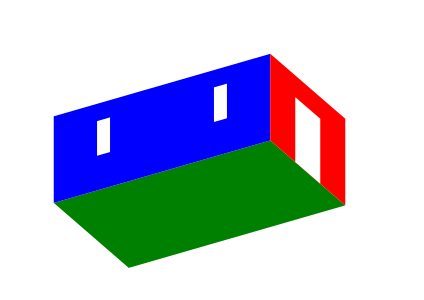

In [304]:
canvas

In [265]:
canvas.transform.focus + (1, 1, 1)

array([1, 1, 1])

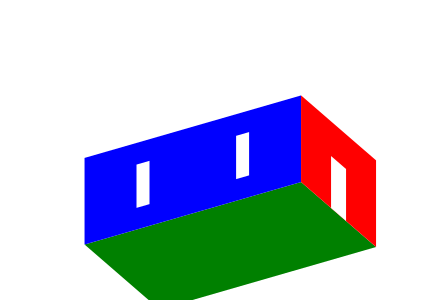

In [273]:
canvas.transform.focus += (0, 0, 1)
canvas

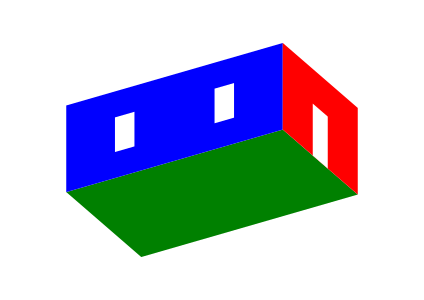

In [213]:
window2.vscale(0.8)
canvas

In [196]:
window1.u = -0.5

In [201]:
window1.u -= 1

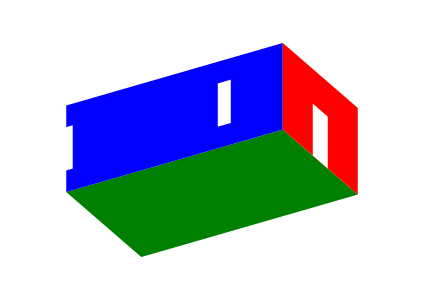

In [202]:
canvas

In [222]:
canvas._repr_svg_()

'<svg width="424" height="300" style="background-color:white"><polygon fill="green" points="141.24682452694518,257.0272228311384 66.24682452694518,192.07531754730547 282.75317547305485,129.57531754730547 357.75317547305485,194.52722283113837"/> <polygon fill="blue" points="66.24682452694518,192.07531754730547 66.24682452694518,105.47277716886163 282.75317547305485,42.97277716886161 282.75317547305485,129.57531754730547"/> <polygon fill="red" points="357.75317547305485,194.52722283113837 357.75317547305485,107.92468245269451 282.75317547305485,42.97277716886161 282.75317547305485,129.57531754730547"/> <polygon fill="white" points="161.50961894323342,142.92468245269453 161.50961894323342,99.62341226347259 187.49038105676658,92.12341226347257 187.49038105676658,135.42468245269453"/> <polygon fill="white" points="327.7531754730548,168.5464607176052 327.7531754730548,116.5849364905389 312.75317547305485,103.59455543377231 312.75317547305485,155.55607966083863"/></svg>'